<img src="../resources/images/Album_Covers.png" width="900">

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Image
import sys
import os

import catboost
import pandas as pd
import numpy as np
import plotly
import plotly.express as px

sys.path.append("../")

In [3]:
# Spotify API interfacte sub-module
from src.spotify.config import (
    MAIN_DATA_FILE, 
    PLAYLIST_FILE, 
    ALBUM_COVER_FILE
)
from src.spotify.utils import read_pickle

# Plotting sub-module
from src.plotting.mood_board import (
    plot_radial_plot, 
    plot_mood_board
)
from src.plotting.album_cover_collage import plot_album_covers

# Streamlit sub-module
from src.streamlit.utils import make_clickable_html

# Modelling sub-module
from src.modelling.config import (
    EUCLIDEAN_FEAT_COLS, 
    CATBOOST_MODEL_FILE
)
from src.modelling.ml_catboost import (
    create_train_test_split,
    get_catboost_predictions,
    train_catboost
)
from src.modelling.ml_data import (
    create_song_pair_features,
    create_song_triplets
)


# Introduction

**«Recommended Frequencies»** is a **recommendation engine for playlists** and currently works for **Spotify** (the app and its code can be found in this [repository](https://github.com/calyptis/RecommendedFrequencies)).
Given a selected playlist in a user's library, the app suggests songs from the user's liked songs that may make a good addition to it.
The goal of the tool is to provide recommendations **solely using information of a user's library**.
Thus, methods like collaborative filtering are outside of the scope.

Specifically, under the current scope, song suggestions are based on a per-user based **Catboost model** that uses
audio features, song attributes and genre information in the form of embeddings provided by [Every Noise at Once](https://everynoise.com/).
The audio features used by the app are a subset of those provided by [Spotify's API](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) 
in addition to the year of the song's album release.

In this blog post I will detail the approach taken to generate music recommendations because after-all:

<img src="../resources/images/Meme.png" width="400">

# Motivation

Memes aside, the motivation is to improve the listening experience by helping users curate their playlists.

Why playlists you may ask? Well, they are an integral means to enjoying music as [350 million users on Spotify may tell you with their 4 billion playlists](https://soundplate.com/how-many-playlists-are-there-on-spotify-and-other-spotify-stats/). But also just based on the most statistically sound evidence – anecdotal evidence.

Generally, the task of music recommendation is nothing novel. Dubolt, Spotibot.com and even Spotify itself already provide such a service. Specifically, for playlist curation, Spotify provides the `Recommended - Based on what's in this playlist` option (but it includes songs not in one's library). Despite this crowded market, I decided to develop a tool myself first and foremost because DIY is fun but also it helped me to re-discover my own music.

# Task

At this point, let me provide a clear description of what I am aiming to achieve.

Imagine having a playlist that captures that feeling of chilling at a pool or lake on a hot summer day. I gave this playlist the very creative name `Pool Side Chill` (I know 😒 - coming up with good playlist names will be another task to tackle). So I have this concept in my head that the playlist should capture. I also added some songs to it. But I am a bit forgetful and need help remembering the songs in my library that fit well into this playlist. This is where Recommended Frequencies comes into play. The goal can be visualised as:

<img src="../resources/images/Goal.png" width="400">

The task of recommending songs for a playlist is **multifaceted** and **difficult** since **music is subjective**.
Depending on the intentions of a listener, a **playlist may capture** any of the below concepts or many others:
    
- Mood (Summertime 🍉)
- Memory (High School 🎓)
- Genre (Rock 🎸)
- Era (80s 📼)

# Data

In order to tackle this task through modelling, the properties of a song need to be quantified in some form. Hopefully in way that retains a lot of the multifaceted aspects of music. But it is important to keep in mind that "music's features do not predict love – music listening does" as the book "This is what it sounds like" by Susan Rogers & Ogi Ogas puts elegantly. So in whatever way one attempts to quantify music, it may never really fully capture the preferences of listeners and what emotion the music evokes.

Nevertheless, progress has been made over the years to apply advanced signal processing techniques and machine learning algorithms for the purpose of extracting high-level features, such as by [1] and [2], to name a few.
Further, various ready-to use implementations exist, such as [Essentia](https://essentia.upf.edu/documentation.html).


Luckily, a convenient starting point is provided by the [Spotify API](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features). The API allows one to pull a lot of information on songs without having to process any raw audio.
Amongst the various high-level song features provided, I decided to consider the following 11 of which I am referencing the [official description](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) below:

1. **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
2. **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
3. **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
4. **Instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
5. **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
6. **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
7. **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words.
8. **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
9. **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
10. **Year of Album Release**
11. **Genre**

Of course many more attributes could be considered, for example the language of the song (if one is, let's say, curating a playlist of French pop songs).
But I am restricting the approach to the above ones for now.

It is worth noting that all features are numerical except for genre, of which more than 5,000 exist on Spotify, ranging from forest psy to new brunswick indie. In the optimal scenario, one would embed genre information in a multidimensional space where similar genres can be found close to each other. With an appropriate similarity metric, one would be one step closer to measuring song similarity in a meaningful way. Luckily (again!), such an effort has already been performed by the website [Every Noise at Once](https://everynoise.com), which provides an "algorithmically-generated […] scatter-plot of the musical genre-space” of Spotify. The y-axis ranges from more organic to more mechanical songs, while the x-axis differentiates between atmospheric and bouncy songs. 

<img src="../resources/images/everynoiseatonce.png" width="400">

By representing genres with their corresponding (x, y) coordinates in the plot, genre embeddings can be obtained. Since genres are identified at an artist level and artists can be associated to more than one genre, I simply average over the 2D coordinates to represent a song in this embedding space.

Now, all features are numerical and after normalisation, they can be conveniently visualised all together in a radial plot. For example, let's take «Cheer Up, My Brother» by HNNY:

In [4]:
# Load saved tracks & their features
df_features = pd.read_pickle(MAIN_DATA_FILE)
# Load all playlists & their songs
list_playlists = read_pickle(PLAYLIST_FILE)
dict_playlists = {playlist["name"][0]: playlist for playlist in list_playlists}

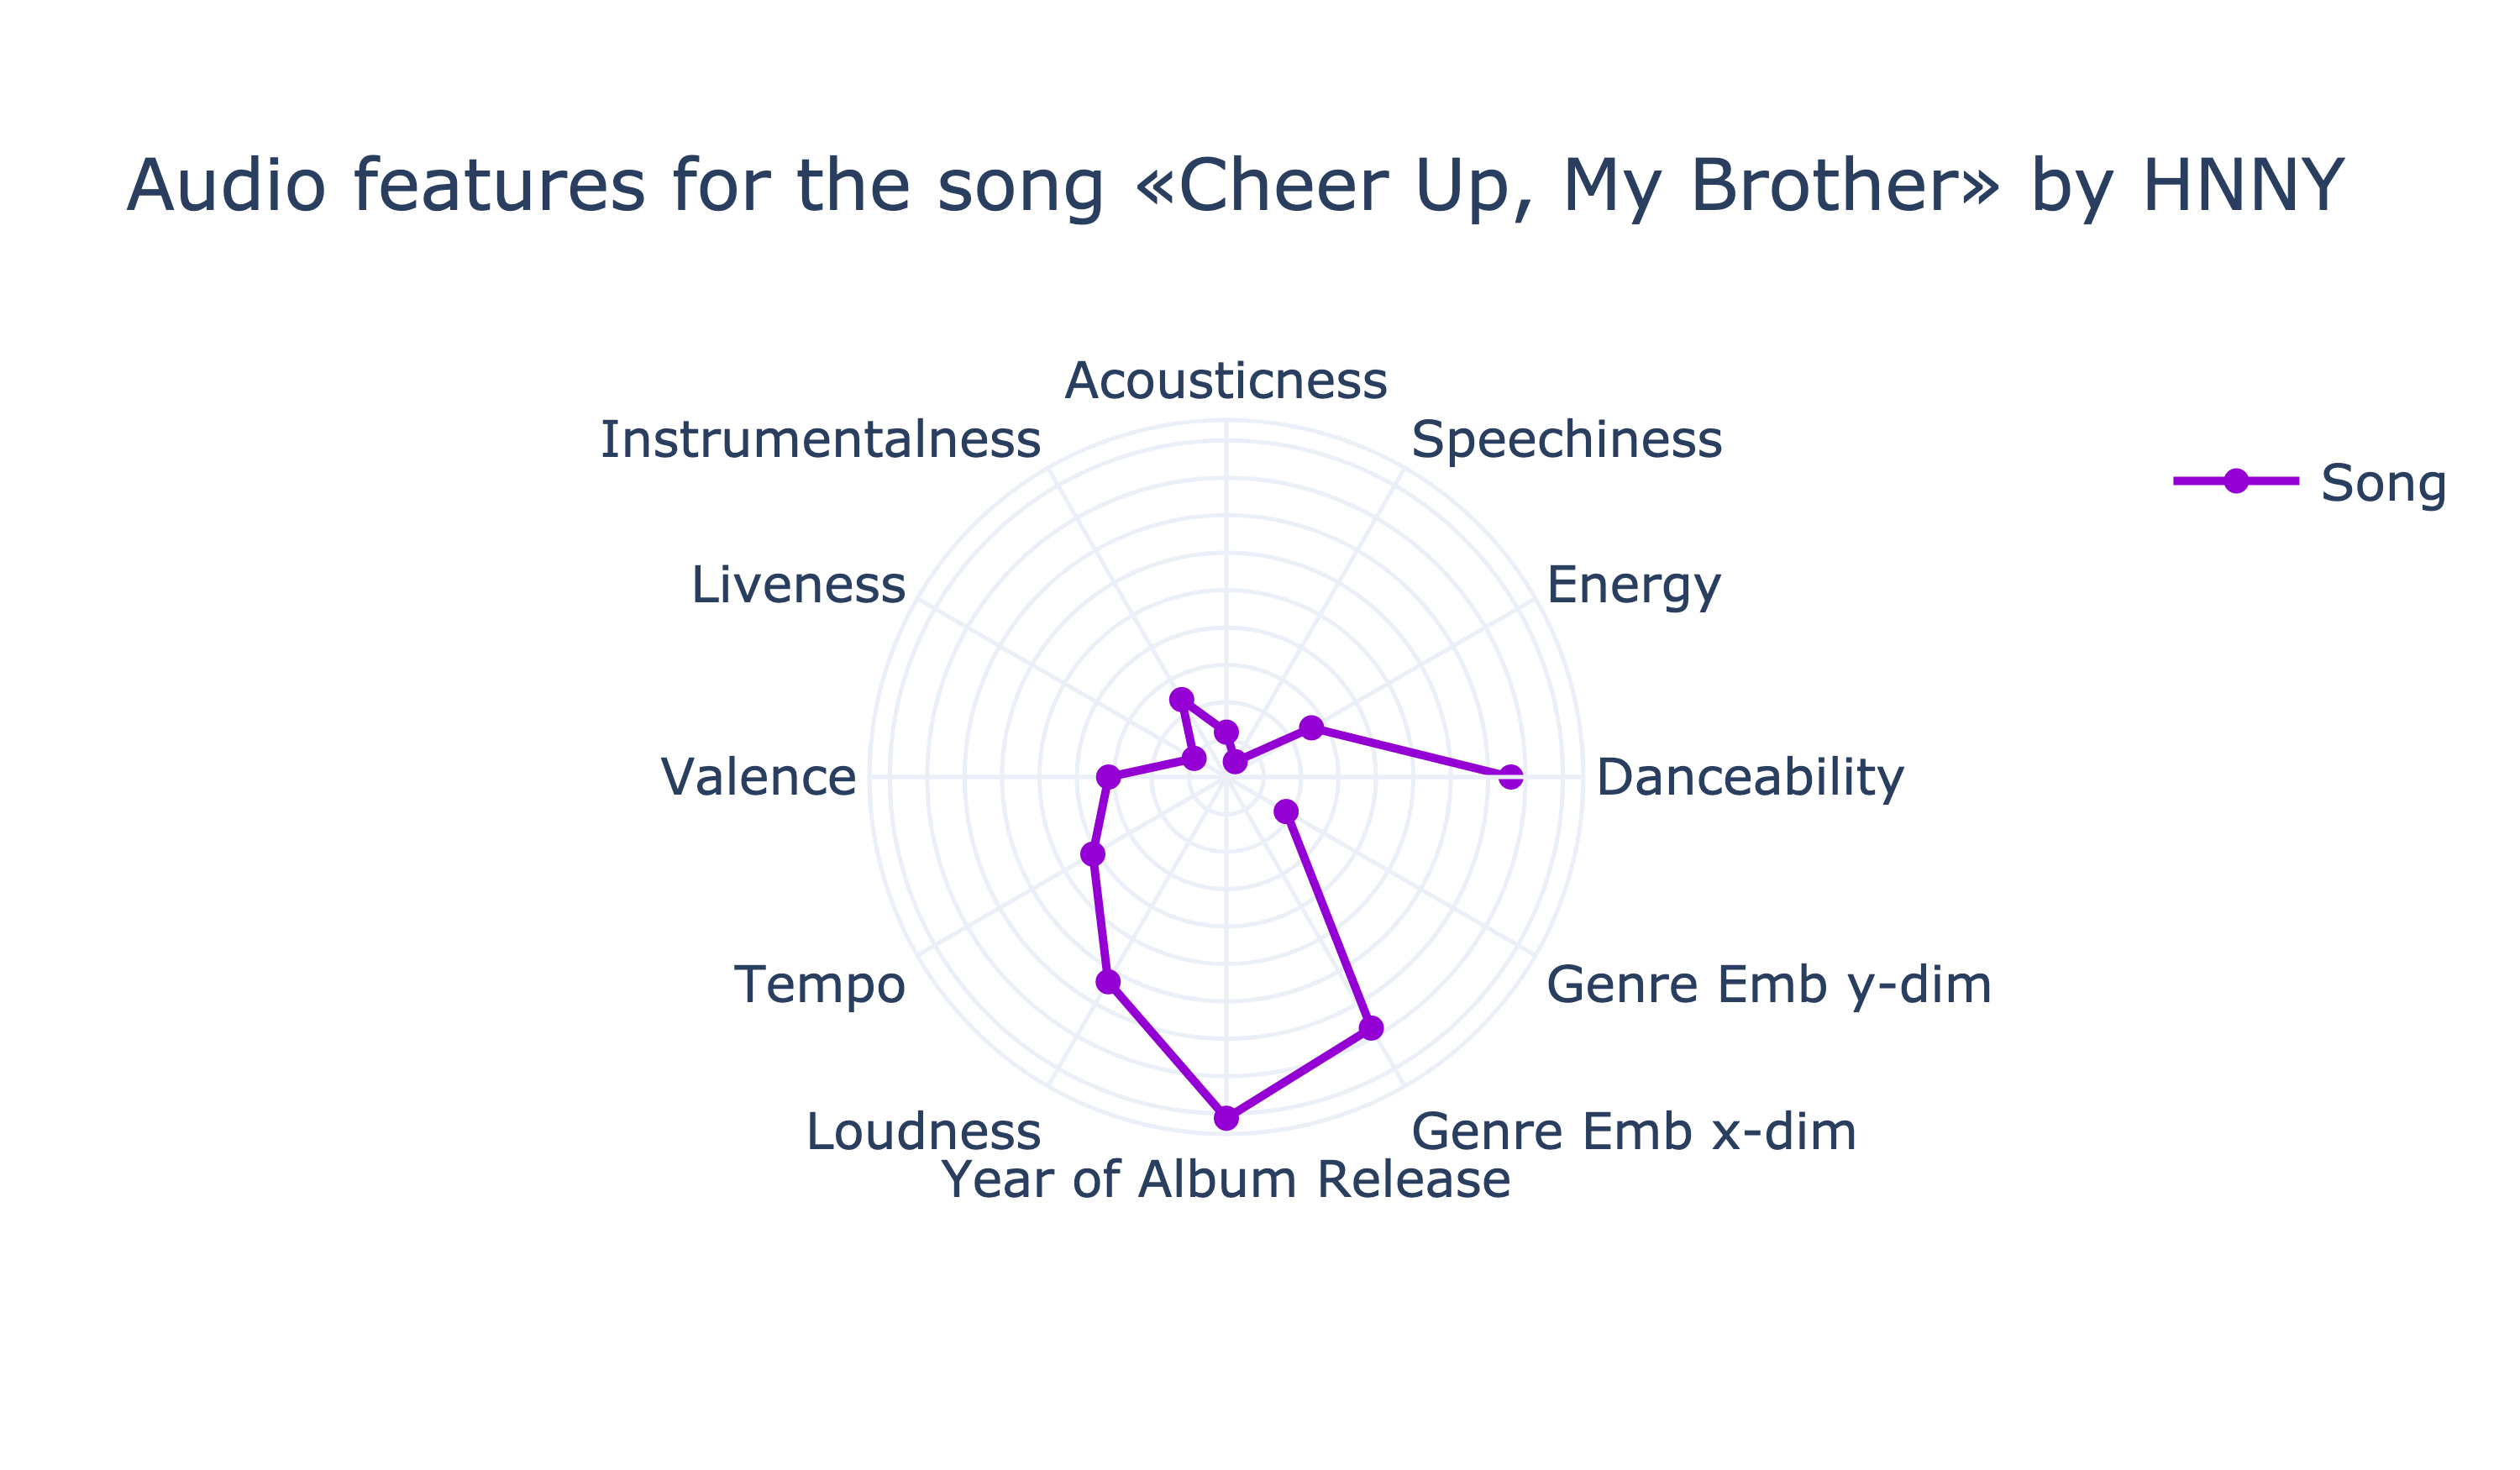

In [5]:
selected_song_id = "37D9O4De2WL1hA6gyResgl"  # Cheer Up, My Brother
selected_song_name, selected_song_artist = df_features.loc[selected_song_id, ["SongName", "Artist"]]

fig = plot_radial_plot(
    df_features.loc[selected_song_id], 
    title=f"Audio features for the song «{selected_song_name}» by {selected_song_artist}",
    inline=False
)
# To render correctly when converting notebook to HMTL using quarto
img_bytes = fig.to_image(format="png", width=600, height=350, scale=5)
Image(img_bytes)

In [6]:
print(f"Genre(s) of {selected_song_artist}:\n\t-  " + "\n\t-  ".join(df_features.loc[selected_song_id, "GenreSet"]))

Genre(s) of HNNY:
	-  indie jazz
	-  electronica
	-  deep house
	-  swedish synthpop
	-  swedish house
	-  swedish electronic
	-  indie soul


# Methodology

With this quantitative description of music, the challenge is to measure the similarity of songs. One important aspect is that such similarity should be conditional on a playlist because the similarity of songs can depend on the context. Hence, generally, not all attributes of songs should be weighted equally or with a fixed weight.

Let's use some examples to illustrate the above point.

Coming back to the `Poll Side Chill` playlist for a hot summer day at the pool, the song [«Cheer Up, My Brother» by the artist HNNY](https://open.spotify.com/track/37D9O4De2WL1hA6gyResgl?si=2205bd7d7e424854) is a fitting match (it is indeed in my playlist).

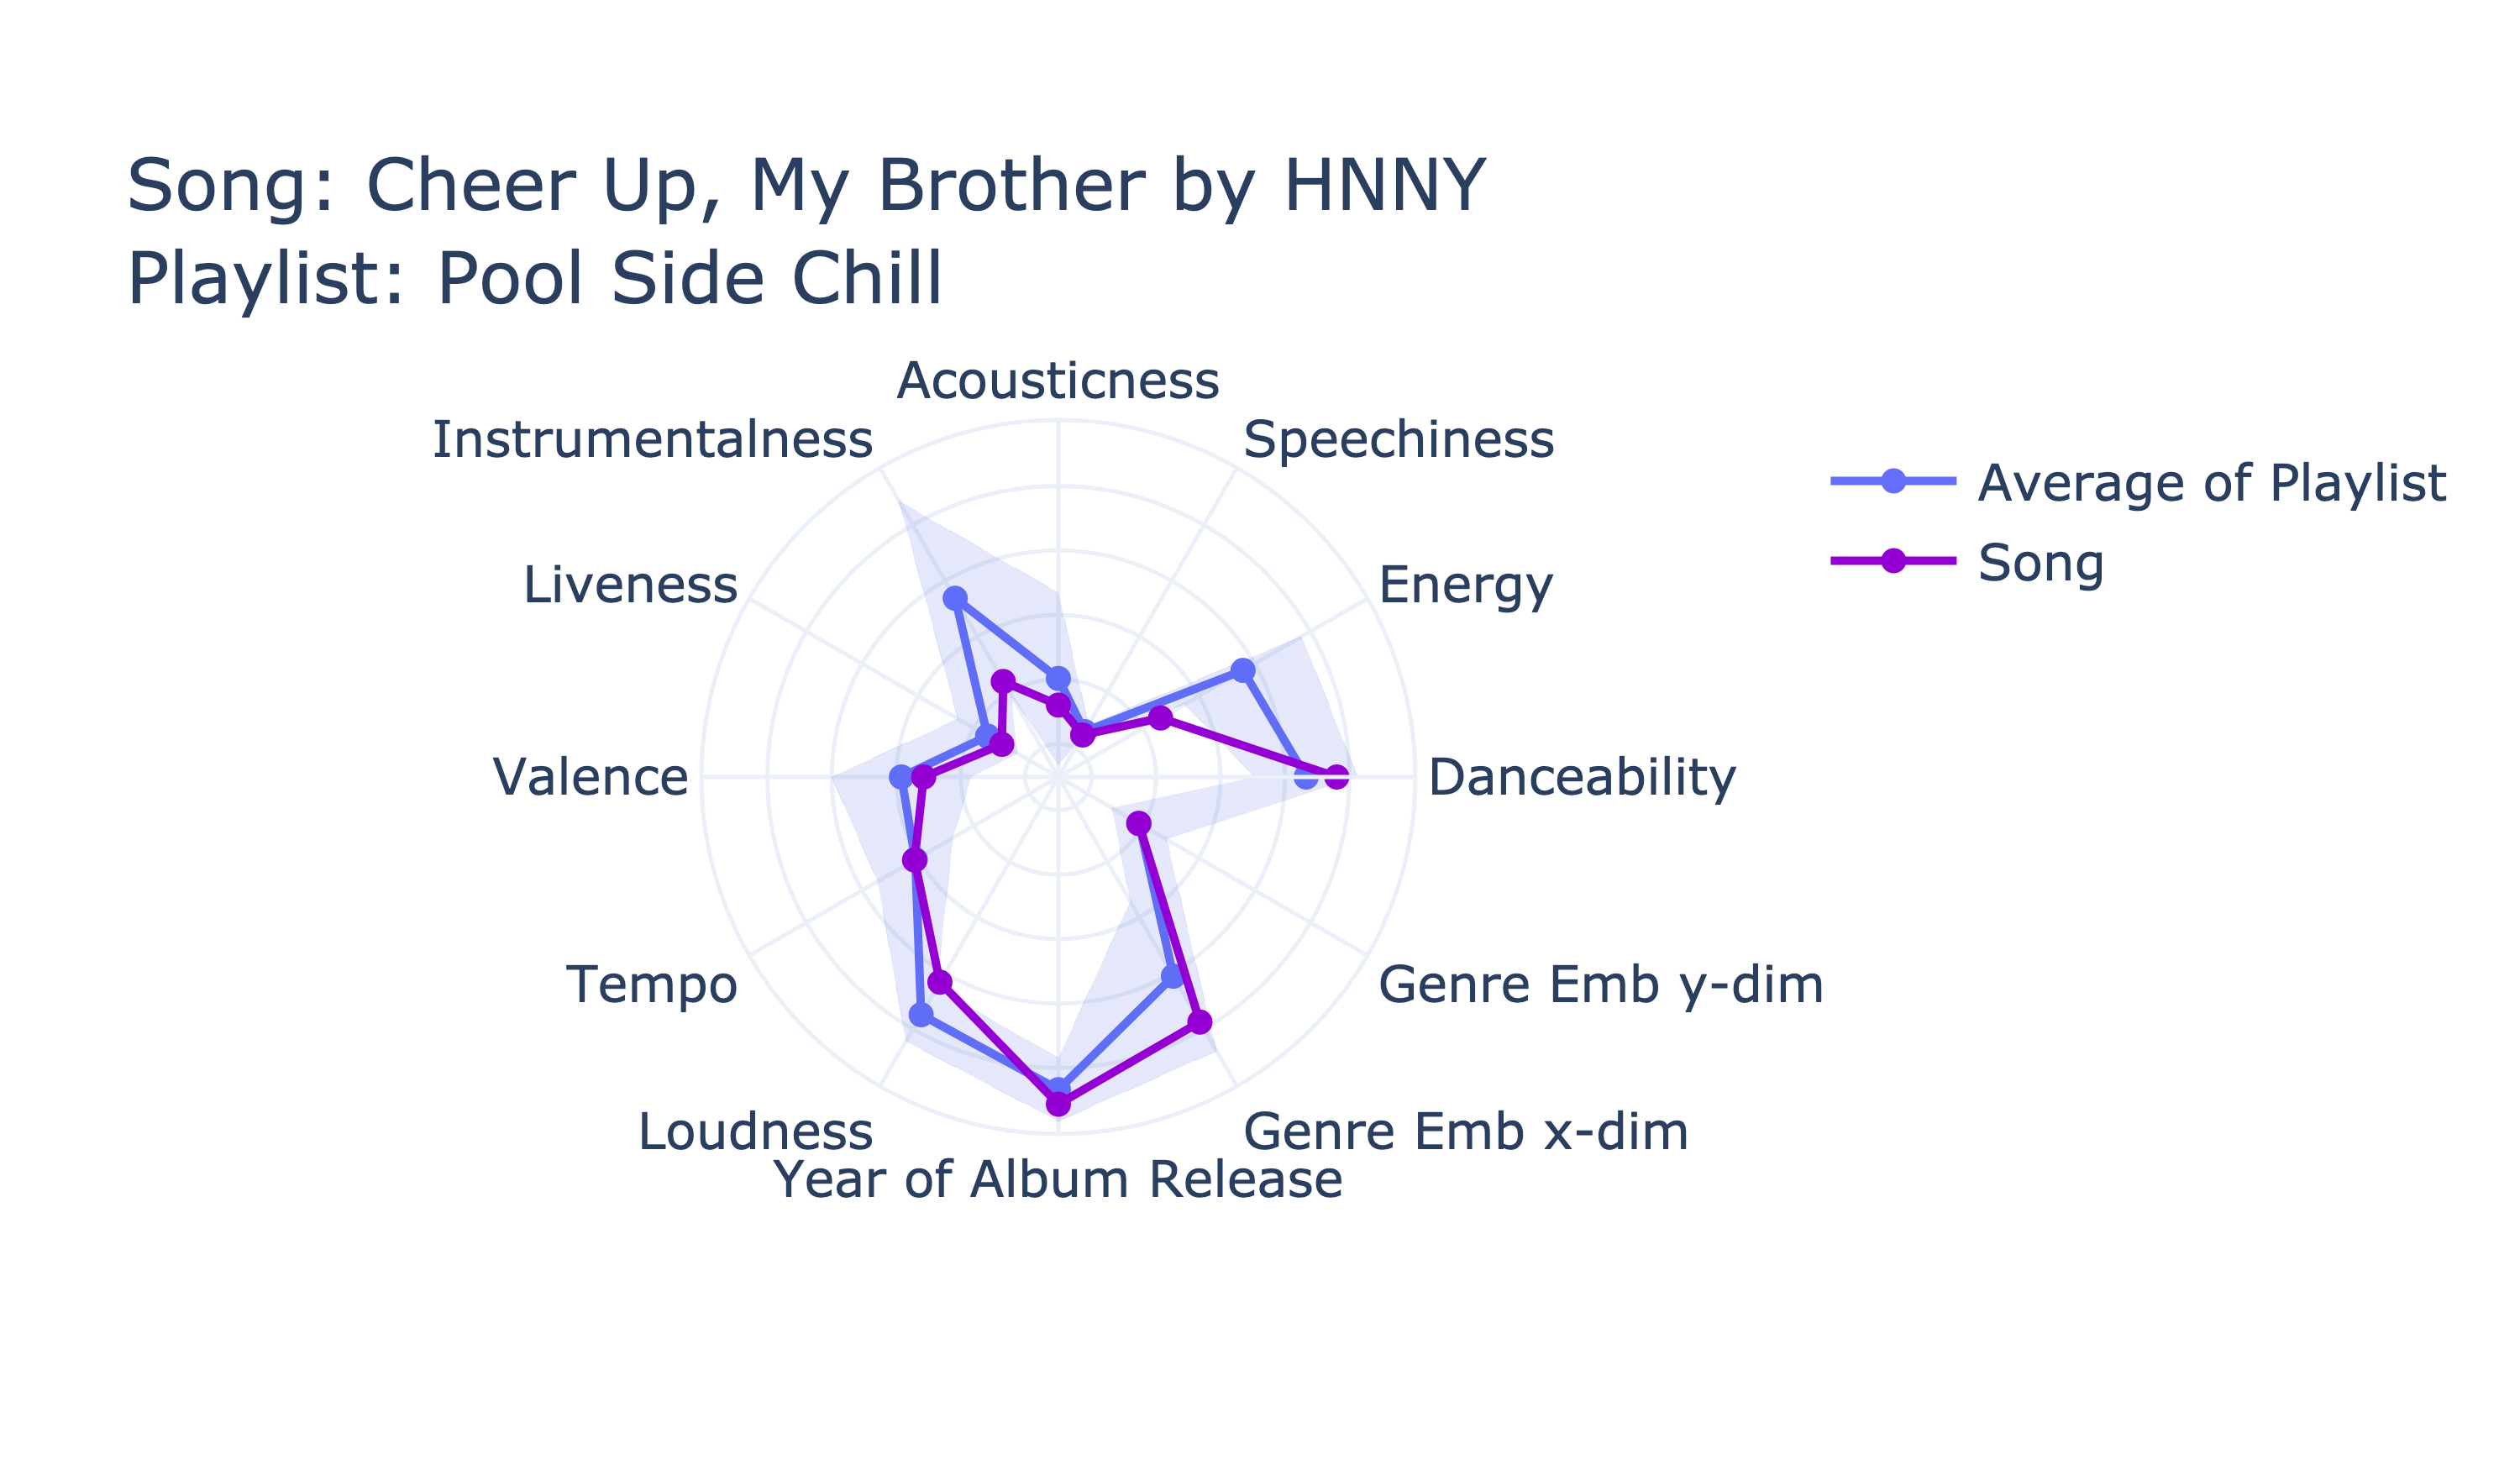

In [7]:
selected_playlist = "Pool Side Chill"

playlist_tracks = dict_playlists[selected_playlist]["tracks"]

good_keys = df_features.index.intersection(playlist_tracks)
df_playlist_features = df_features.loc[good_keys]

mood_board = plot_mood_board(
    df_playlist_features[EUCLIDEAN_FEAT_COLS], title="", inline=False, metrics_version=1
)
song_radial_plot_trace = plot_radial_plot(
    df_features.loc[selected_song_id].copy(),
    title=f"{selected_song_name} by {selected_song_artist}",
    only_return_trace=True,
)
mood_board.add_trace(song_radial_plot_trace)
mood_board.update_layout(
    title=f"Song: {selected_song_name} by {selected_song_artist}"
    + "<br>"
    + f"Playlist: {selected_playlist}"
)
# To render correctly when converting notebook to HMTL using quarto
img_bytes = mood_board.to_image(format="png", width=600, height=350, scale=5)
Image(img_bytes)

On the other hand, by the same standards of similarity, the song [«Brothers» by City of the Sun](https://open.spotify.com/track/4lyjuPi3pGN6oTQSK6CUEa?si=ce866e5dd97344ad) seems to be a fitting match for my playlist containing slow paced classical music (which I named «Classico - Adagio»), such as [«La Nascita Delle Cose Segrete» by Ludovico Einaudi](https://open.spotify.com/track/3nXCKdGO2Ub6kBlw50EFkS?si=72ebc32447fb47e8) or [«Dream 13 (minus even)» by Max Richter](https://open.spotify.com/track/6CZQOWmIA9GymbjdaEJcGu?si=a9c00cfa03484bd4).

But as subjective as music may be, I think we all agree that «Brothers» is not a good match for such a playlist.

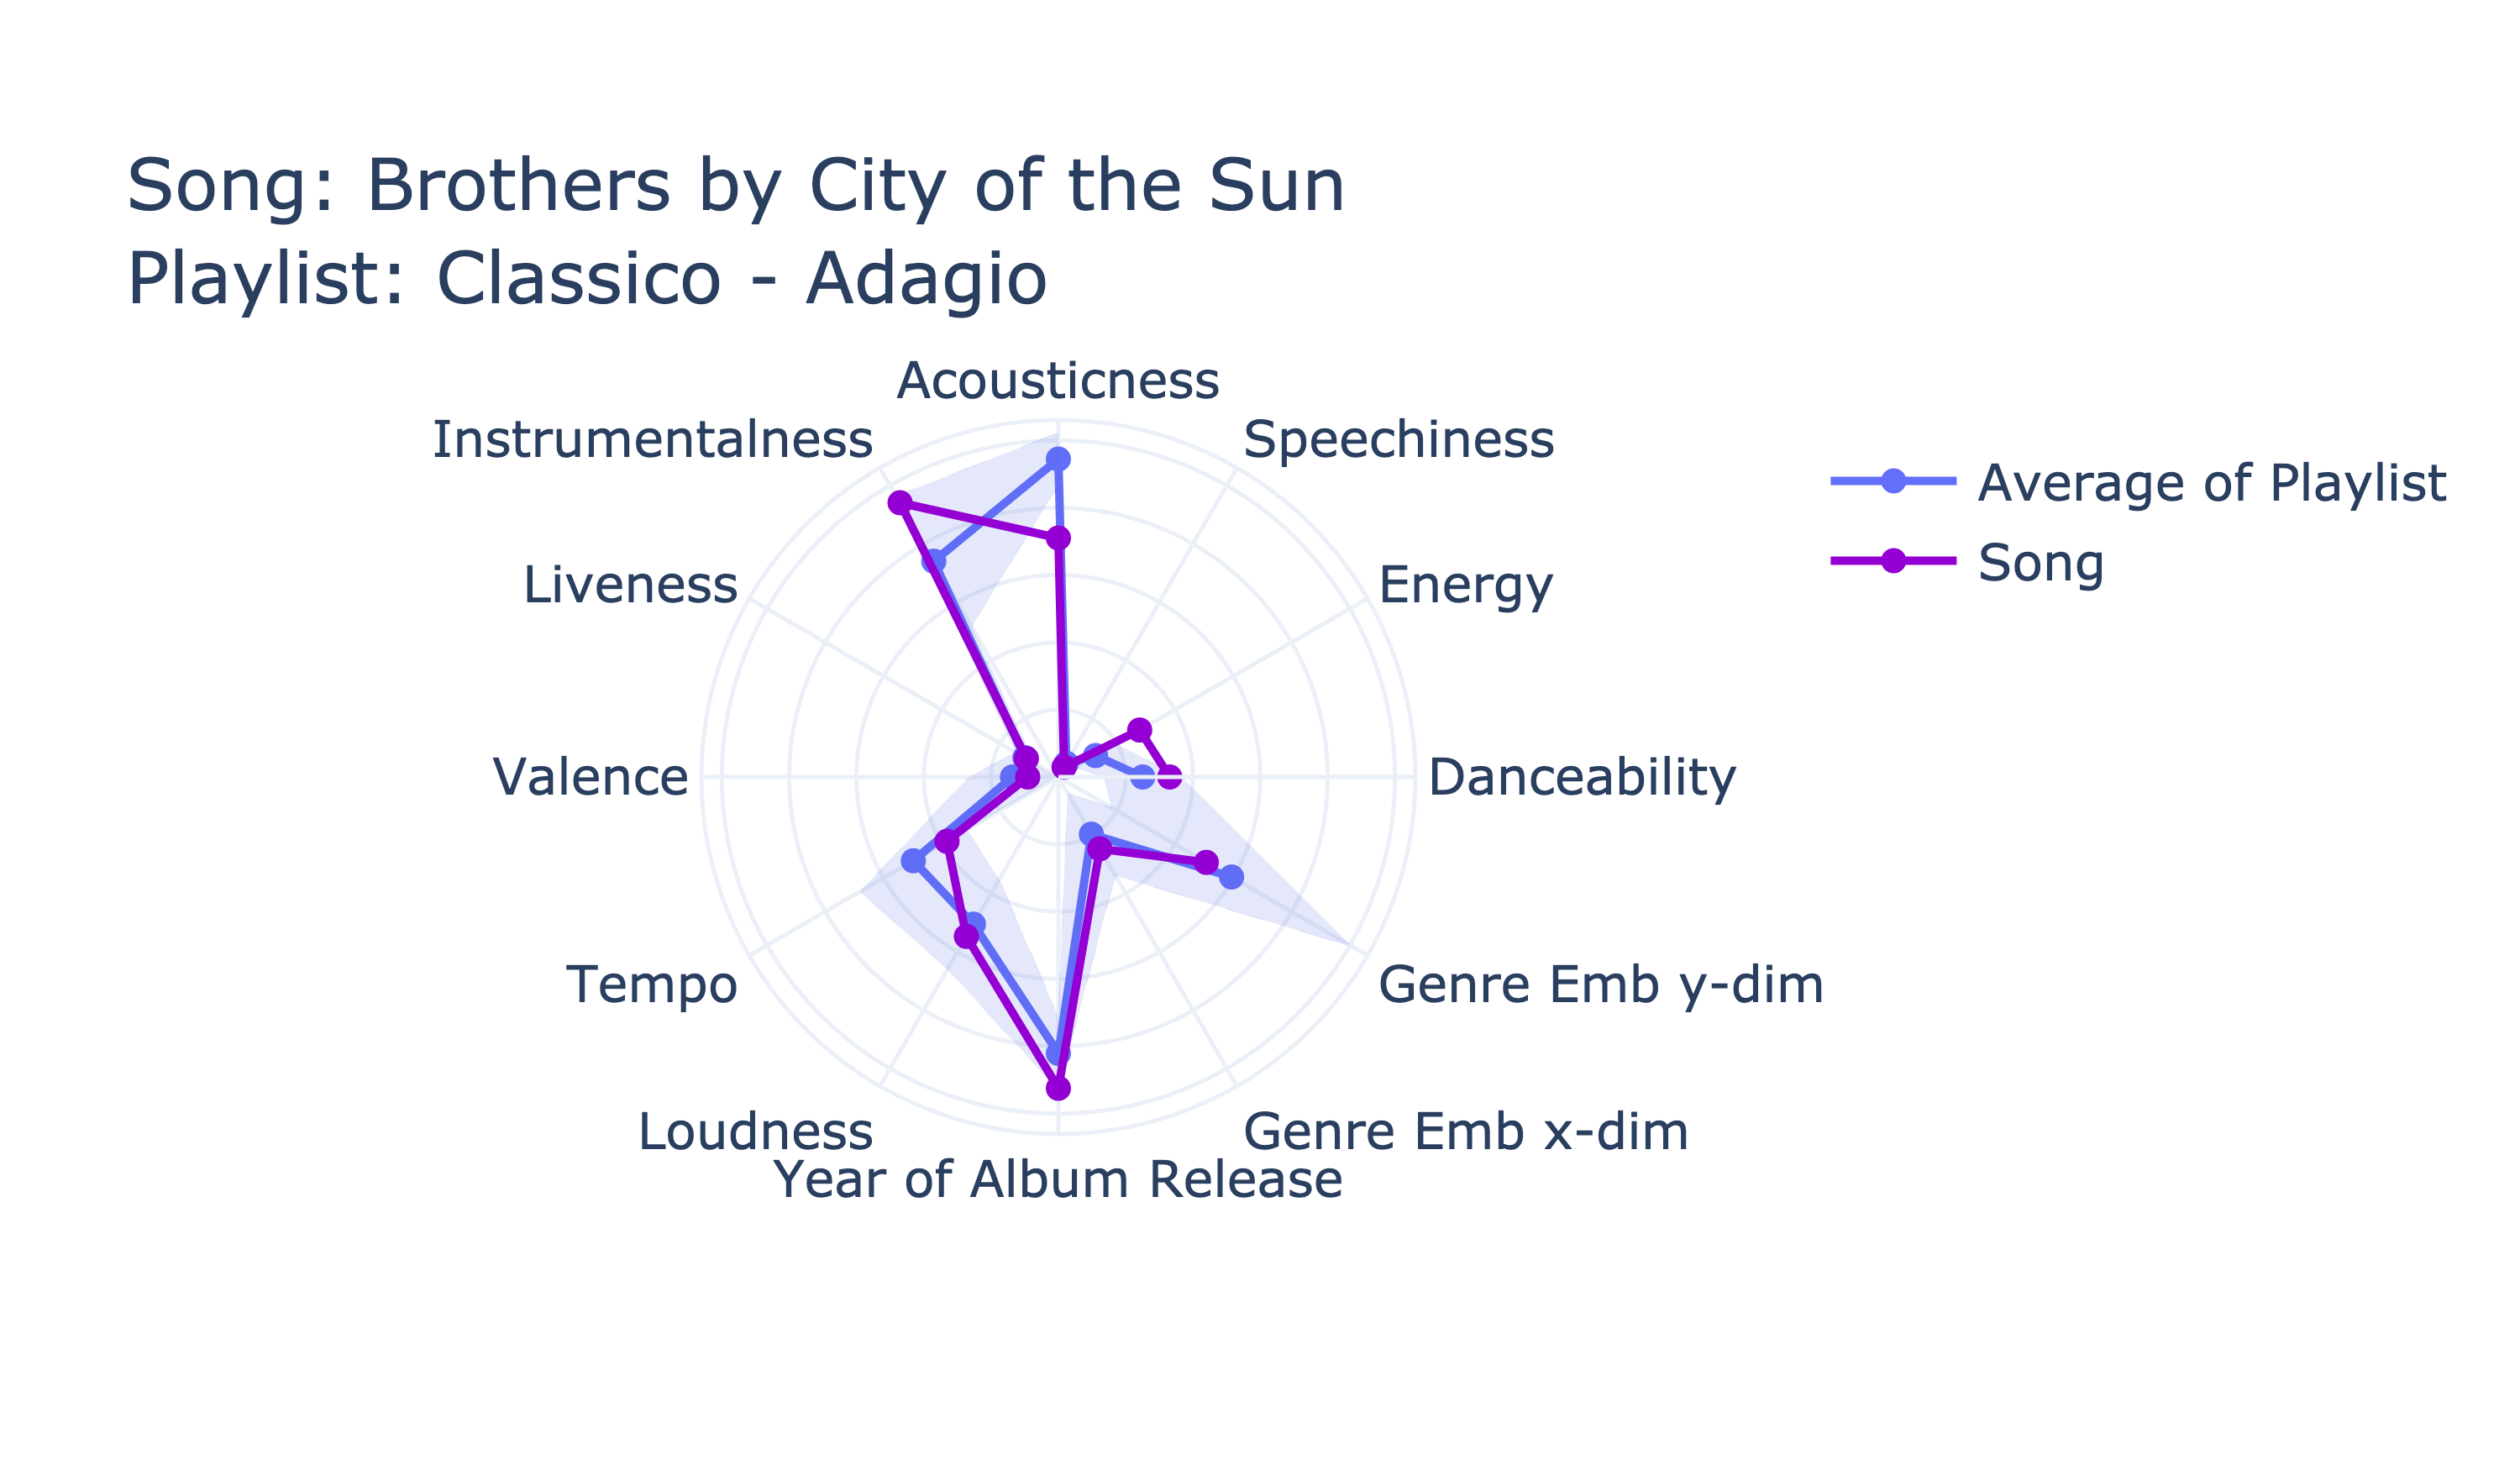

In [8]:
selected_playlist = "Classico - Adagio"
selected_song_id = "4lyjuPi3pGN6oTQSK6CUEa"  # Brothers, by City of the Sun
selected_song_name, selected_song_artist = df_features.loc[selected_song_id, ["SongName", "Artist"]]

playlist_tracks = dict_playlists[selected_playlist]["tracks"]

good_keys = df_features.index.intersection(playlist_tracks)
df_playlist_features = df_features.loc[good_keys]

mood_board = plot_mood_board(
    df_playlist_features[EUCLIDEAN_FEAT_COLS], title="", inline=False, metrics_version=1
)
song_radial_plot_trace = plot_radial_plot(
    df_features.loc[selected_song_id].copy(),
    title=f"{selected_song_name} by {selected_song_artist}",
    only_return_trace=True,
)
mood_board.add_trace(song_radial_plot_trace)
mood_board.update_layout(
    title=f"Song: {selected_song_name} by {selected_song_artist}"
    + "<br>"
    + f"Playlist: {selected_playlist}"
)
# To render correctly when converting notebook to HMTL using quarto
img_bytes = mood_board.to_image(format="png", width=600, height=350, scale=5)
Image(img_bytes)

I hope this example illustrates that similarity of songs as described by their high-level song features is somewhat dependent on the context.

Given this aspect, I decided to solve the task using **Machine Learning** in order to automatically learn the weights each audio feature should play for measuring similarity in the context of a specific playlist. 
Specifically, a **Catboost** model is trained to learn to recognise that songs belonging to the same playlist are similar and those from different playlists are contrastive. 
In other words, the model is trained by setting up positive and negative examples. 

This means that triples are created, that are further conditioned on a playlist.
Each triple is in the format of<br/> (`anchor`, `positive example`, `negative example`, `playlist`).

`anchor` is a specific song and given a `playlist` (i.e. context), the `positive example` is another song in the same playlist whereas the `negative example` is a song in a different playlist.
Here, the adjective «different» is important. We want to create clear negative examples because some playlists may be highly related, for example one containing Trap music and the other Hip Hop.
I therefore decided to list pairs of similar playlists in my library and only sample negative examples from playlists not deemed similar for a given `playlist`. 

One example of a triple is:

In [9]:
df_triples = create_song_triplets()
example = df_triples.query("playlist == 'Pool Side Chill'").iloc[0]
anchor = "«{0}» by {1}".format(
    *df_features.loc[example.anchor, ["SongName", "Artist"]].values
)
positive_example = "«{0}» by {1}".format(
    *df_features.loc[example.positive_example, ["SongName", "Artist"]].values
)
negative_example = "«{0}» by {1}".format(
    *df_features.loc[example.negative_example, ["SongName", "Artist"]].values
)
print(
    "Anchor: {}\nPositive Example: {}\nNegative Example: {}"
    .format(anchor, positive_example, negative_example)
)

Anchor: «What's the Use?» by Mac Miller
Positive Example: «Cheer Up, My Brother» by HNNY
Negative Example: «Walking in Memphis» by Marc Cohn


These triples are then simply transformed into labelled pairs, where the (`anchor`, `positive_example`) gets a label of 1 and the pair with the `negative_example` a label of 0. When constructing the pairs, their feature vectors are concatenated.

For the example above, one gets this feature vector, which is shown as a matrix by stacking the vectors of the anchor and the positive example:

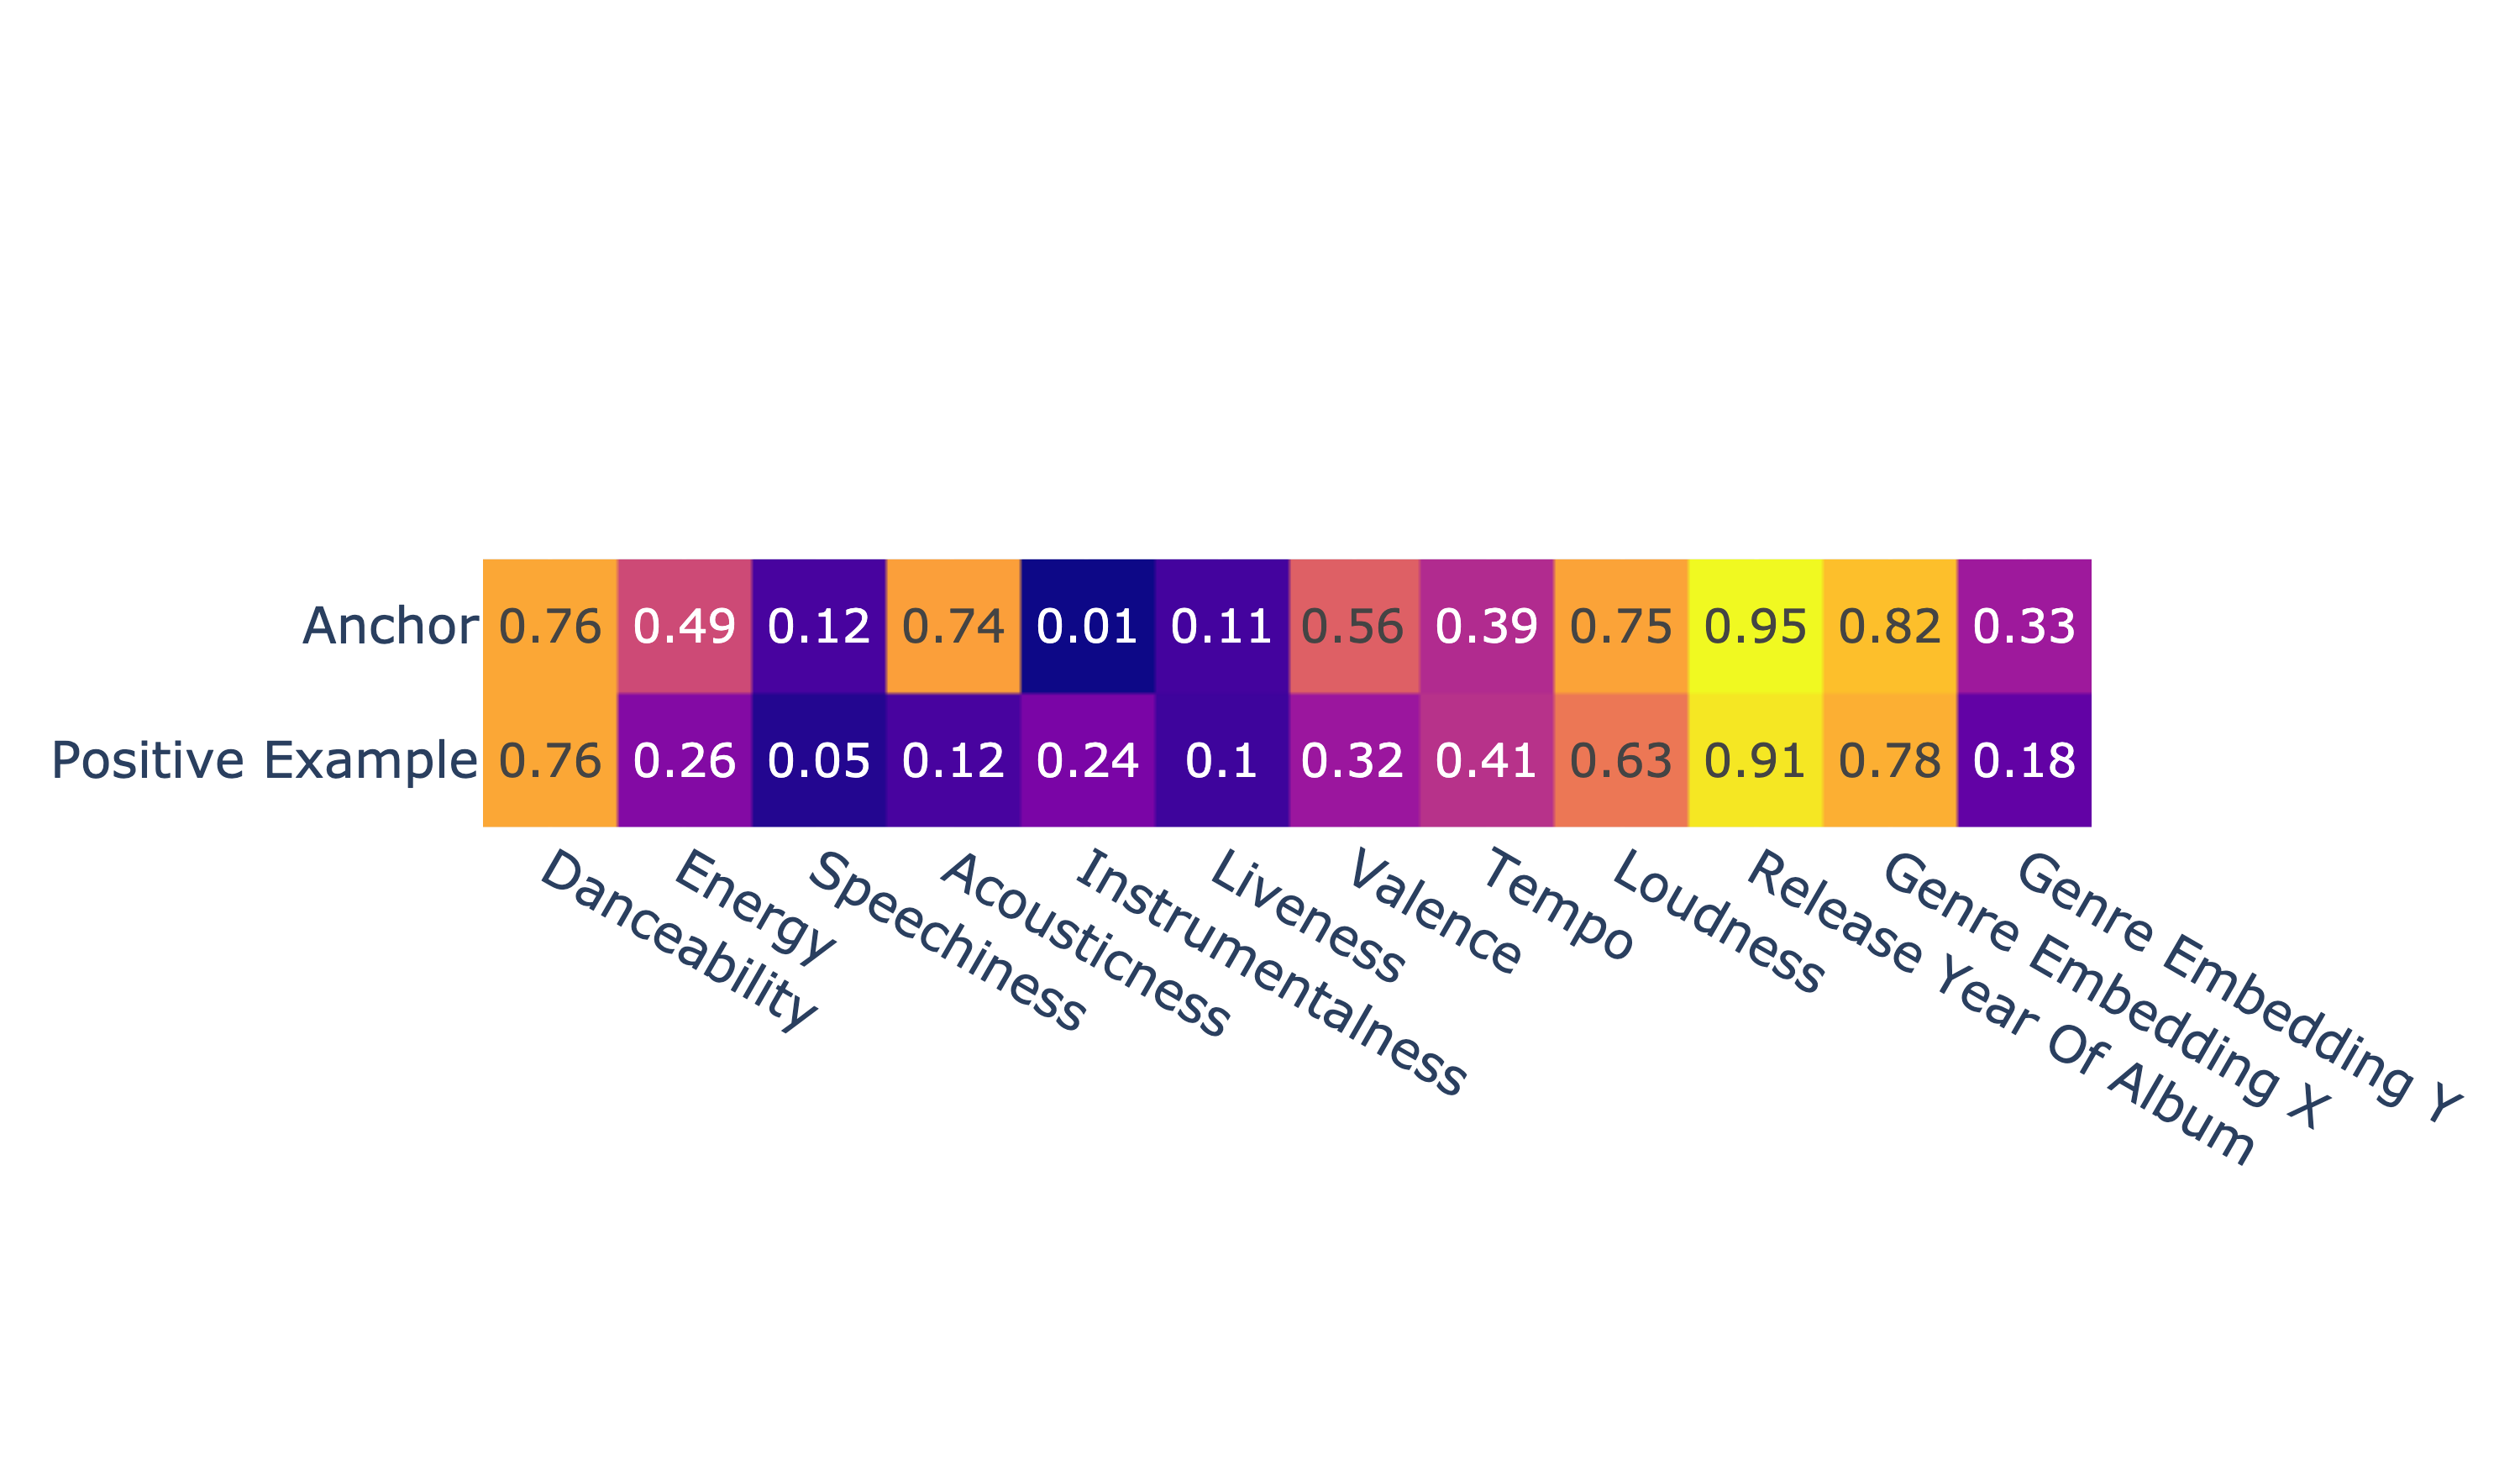

In [11]:
df_pairs = create_song_pair_features(df_triples)
m = (
    df_pairs
    .query("playlist == 'Pool Side Chill'")
    .loc[[(example.anchor, example.positive_example)]]
    .values[:, :-2]
    .flatten()
    .astype(float)
)
m = m.reshape((2, int(m.shape[0]/2)))
rename_dict = {
    "GenreEveryNoiseEmbeddingX": "Genre Embedding X",
    "GenreEveryNoiseEmbeddingY": "Genre Embedding Y",
    "AlbumReleaseYear": "Release Year of Album"
}
x_ticks = [rename_dict.get(i, i) for i in EUCLIDEAN_FEAT_COLS]
x_ticks = list(map(str.title, x_ticks))

fig = px.imshow(
    np.around(m, 2), 
    text_auto=True,
    x=x_ticks,
    y=["Anchor", "Positive Example"]
)
fig.update_layout(coloraxis_showscale=False)
img_bytes = fig.to_image(format="png", width=600, height=350, scale=5)
Image(img_bytes)

The `playlist` information is subsequently one-hot-encoded.

With this set-up, the Catboost model is able to pick up on song similarities thanks to the high level song features but also based on the context (i.e. `playlist`).

When performing inference, the Catboost model predicts the similarity score (model probability) for every pair of a candidate song and the songs in a playlist. The average similarity scores is then taken for each candidate song. The higher the similarity score, the better the match (according to the model).

# Results

Having outlined the task and the methodology, we can now turn to some results.

## Example # 1

I have decided to create a playlist capturing my favourite music with that 80's vibe.

In [12]:
album_covers = read_pickle(ALBUM_COVER_FILE)
d_playlist_album_covers = {i[0]: i[-1] for i in album_covers}

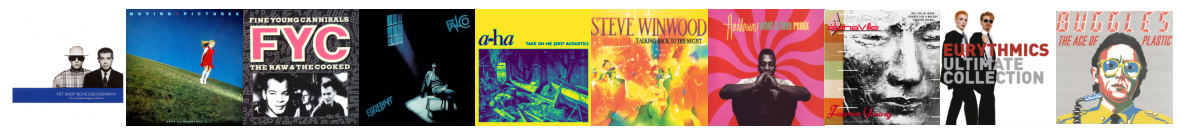

In [13]:
selected_playlist = "80's"
fig = plot_album_covers(d_playlist_album_covers[selected_playlist], facecolor="white")

I have already managed to populate it with some songs – here's an extract:

In [14]:
COL_ORDER = [
    # "PreviewURL", 
    "SongName", 
    "Artist"
]
playlist_tracks = dict_playlists[selected_playlist]["tracks"]
playlist_tracks = list(
    set(dict_playlists[selected_playlist]["tracks"]) &
    set(df_features.index)
)
(
    df_features
    .loc[playlist_tracks]
    .reset_index()[COL_ORDER]
    .head(10)
    # .style.format({"PreviewURL": make_clickable_html})
)

,SongName,Artist
0,Take Me Home Tonight,Eddie Money
1,Missing You,John Waite
2,I'm So Excited,The Pointer Sisters
3,West End Girls,Pet Shop Boys
4,The Riddle,Nik Kershaw
5,Sussudio - 2016 Remaster,Phil Collins
6,Self Control,Laura Branigan
7,Forever Young,Alphaville
8,La Isla Bonita,Madonna
9,Uptown Girl,Billy Joel


Now I would like to sift through the rest of my library and get some good recommendations of songs that could be add to this playlist.

In [15]:
# Train the catboost model
# If already trained, load it from disk
if not os.path.exists(CATBOOST_MODEL_FILE):
    df_example_triplets = create_song_triplets()
    df_features_for_model = create_song_pair_features(df_example_triplets)
    df_train, df_test = create_train_test_split(df_features_for_model)
    model_catboost = train_catboost(df_train, df_test)
    model_catboost.save_model(CATBOOST_MODEL_FILE)
else:
    model_catboost = catboost.CatBoostClassifier()
    model_catboost.load_model(fname=CATBOOST_MODEL_FILE)

In [16]:
# Obtain suggestions

# Track information in a pretty format
df_track_info = df_features[[i for i in COL_ORDER if i != "ID"]].copy()

# Songs and their features for modelling (those of the playlist)
df_playlist_features = df_features.loc[playlist_tracks]

# Songs we we consider for predictions and their features
# only considering songs that are not already in the playlist
songs_available_for_suggestion = list(
    set(df_features.index) - 
    set(dict_playlists[selected_playlist]["tracks"])
)
df_songs_available_for_suggestion_features = df_features.loc[
    songs_available_for_suggestion
].copy()

# For each candidate song in `songs_available_for_suggestion`
# measure the similarity w.r.t every song in the playlist
# Sort the candidate songs by decreasing similarity
recommendations = get_catboost_predictions(
    df_playlist_features=df_playlist_features,
    df_songs_available_for_suggestion_features=df_songs_available_for_suggestion_features,
    model_catboost=model_catboost,
    playlist_name=selected_playlist,
)
top_10_recommendations = recommendations.head(10)

# Make results pretty
df_suggested_songs_info = df_track_info.join(
    top_10_recommendations, how="inner"
).sort_values(by="Similarity", ascending=False)

In [17]:
df_suggested_songs_info.reset_index(drop=True)

,SongName,Artist,Similarity
0,"Holding Out for a Hero - From ""Footloose"" Soun...",Bonnie Tyler,0.988707
1,Maniac,Michael Sembello,0.976435
2,Take Me Home - 2016 Remaster,Phil Collins,0.969008
3,West End Girls - 2001 Remaster,Pet Shop Boys,0.967344
4,Alan Watts Blues,Van Morrison,0.961876
5,Conga,Gloria Estefan,0.960995
6,Mercy,The Third Degree | Jon Allen,0.960296
7,I'm Gonna Be (500 Miles),The Proclaimers,0.959934
8,"Footloose - From ""Footloose"" Soundtrack",Kenny Loggins,0.957814
9,Money's Too Tight (To Mention) - 2008 Remaster,Simply Red,0.956260


Let's look at how well the first recommendation fits into the playlist from a visual perspective by looking at the high level song features.

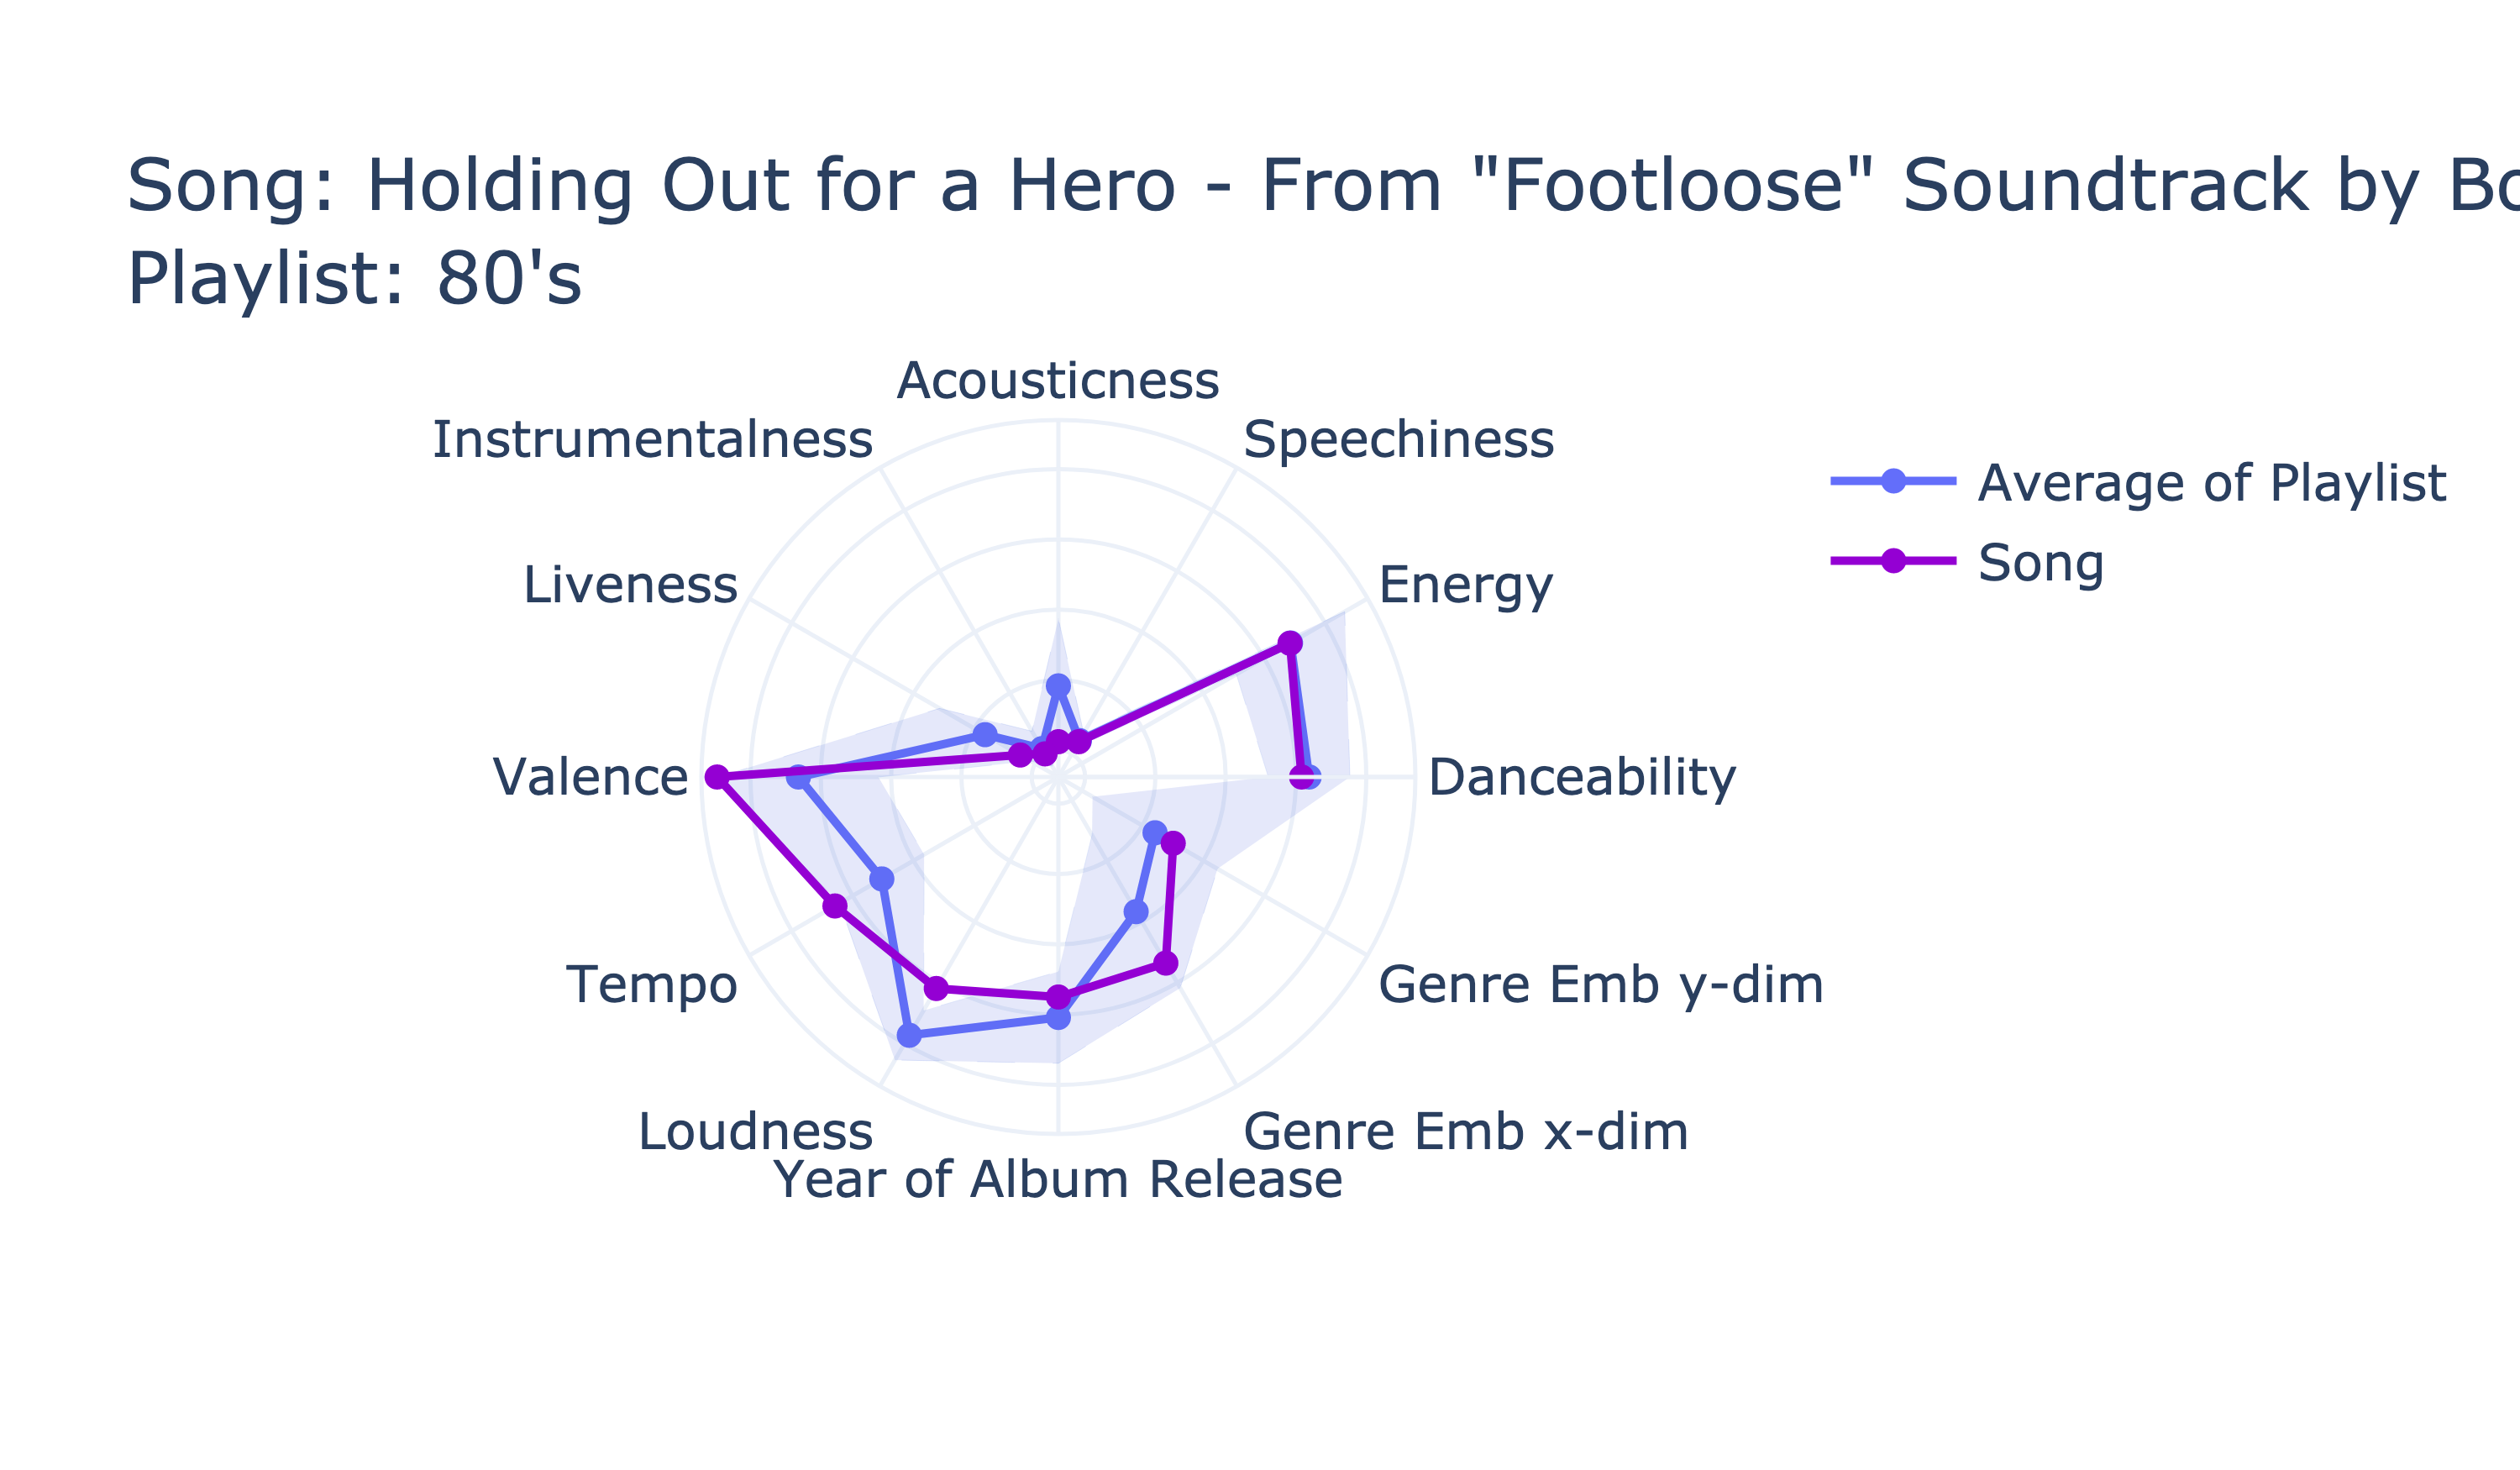

In [18]:
selected_song_id = df_suggested_songs_info.index[0]
selected_song_name, selected_song_artist = df_features.loc[selected_song_id, ["SongName", "Artist"]]

mood_board = plot_mood_board(
    df_playlist_features[EUCLIDEAN_FEAT_COLS], title="", inline=False, metrics_version=1
)
song_radial_plot_trace = plot_radial_plot(
    df_features.loc[selected_song_id].copy(),
    title=f"{selected_song_name} by {selected_song_artist}",
    only_return_trace=True,
)
mood_board.add_trace(song_radial_plot_trace)
mood_board.update_layout(
    title=f"Song: {selected_song_name} by {selected_song_artist}"
    + "<br>"
    + f"Playlist: {selected_playlist}"
)
# To render correctly when converting notebook to HMTL using quarto
img_bytes = mood_board.to_image(format="png", width=600, height=350, scale=5)
Image(img_bytes)

The model really picked a good candidate here! (That's my preference talking now, but someone else might disagree😅).

Let's have a look at a second example.

## Example # 2

The second playlist I want to showcase is one that contains my favourite rock-ish / folk-ish songs, that are on the slow-ish side.

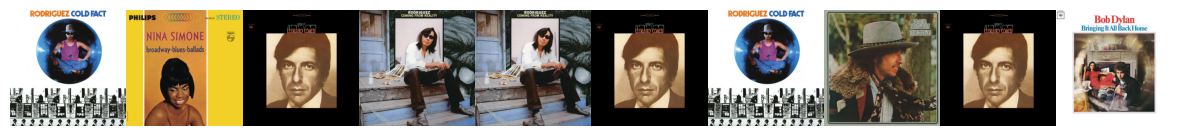

In [19]:
selected_playlist = "Rock - Folk"
fig = plot_album_covers(d_playlist_album_covers[selected_playlist], facecolor="white")

The playlist features only few albums/artists, that's why some of the album covers are duplicated above. So this makes the playlist a great choice, because I would like to diversify it a bit..

Here are some of the songs in the playlist:

In [20]:
playlist_tracks = dict_playlists[selected_playlist]["tracks"]
playlist_tracks = list(
    set(dict_playlists[selected_playlist]["tracks"]) &
    set(df_features.index)
)
(
    df_features
    .loc[playlist_tracks]
    .reset_index()[COL_ORDER]
    .head(10)
)

,SongName,Artist
0,Like a Rolling Stone,Bob Dylan
1,Don't Let Me Be Misunderstood,Nina Simone
2,Suzanne,Leonard Cohen
3,I Wonder,Rodríguez
4,Hurricane,Bob Dylan
5,"So Long, Marianne",Leonard Cohen
6,Crucify Your Mind,Rodríguez
7,Mr. Tambourine Man,Bob Dylan
8,"Hey, That's No Way to Say Goodbye",Leonard Cohen
9,I Think Of You,Rodríguez


With this information, the model suggests the following Top 10 songs to me:

In [21]:
# Obtain suggestions

# Track information in a pretty format
df_track_info = df_features[[i for i in COL_ORDER if i != "ID"]].copy()

# Songs and their features for modelling (those of the playlist)
df_playlist_features = df_features.loc[playlist_tracks]

# Songs we we consider for predictions and their features
# only considering songs that are not already in the playlist
songs_available_for_suggestion = list(
    set(df_features.index) - 
    set(dict_playlists[selected_playlist]["tracks"])
)
df_songs_available_for_suggestion_features = df_features.loc[
    songs_available_for_suggestion
].copy()

# For each candidate song in `songs_available_for_suggestion`
# measure the similarity w.r.t every song in the playlist
# Sort the candidate songs by decreasing similarity
recommendations = get_catboost_predictions(
    df_playlist_features=df_playlist_features,
    df_songs_available_for_suggestion_features=df_songs_available_for_suggestion_features,
    model_catboost=model_catboost,
    playlist_name=selected_playlist,
)
top_10_recommendations = recommendations.head(10)

# Make results pretty
df_suggested_songs_info = df_track_info.join(
    top_10_recommendations, how="inner"
).sort_values(by="Similarity", ascending=False)

In [22]:
df_suggested_songs_info.reset_index(drop=True)

,SongName,Artist,Similarity
0,"Quizas, Quizas, Quizas (Perhaps, Perhaps, Perh...",Nat King Cole,0.981620
1,Blowin' in the Wind,Bob Dylan,0.970832
2,Come Fly With Me,Frank Sinatra,0.968261
3,Beyond the Sea,Bobby Darin,0.967110
4,The Times They Are A-Changin',Bob Dylan,0.967107
5,Four Women,Nina Simone,0.961116
6,"It Ain't Me, Babe",Bob Dylan,0.961099
7,Positively 4th Street,Bob Dylan,0.958995
8,Feeling Good,Nina Simone,0.954881
9,American Pie,Don McLean,0.952283


The model mostly sticked to Bob Dylan and Nina Simone (a safe recommendation!) but it also nicely diversified.

I especially appreciate the suggestion of [«American Pie» by Don McLean](https://open.spotify.com/track/1fDsrQ23eTAVFElUMaf38X?si=56a3877eb48c4b73).

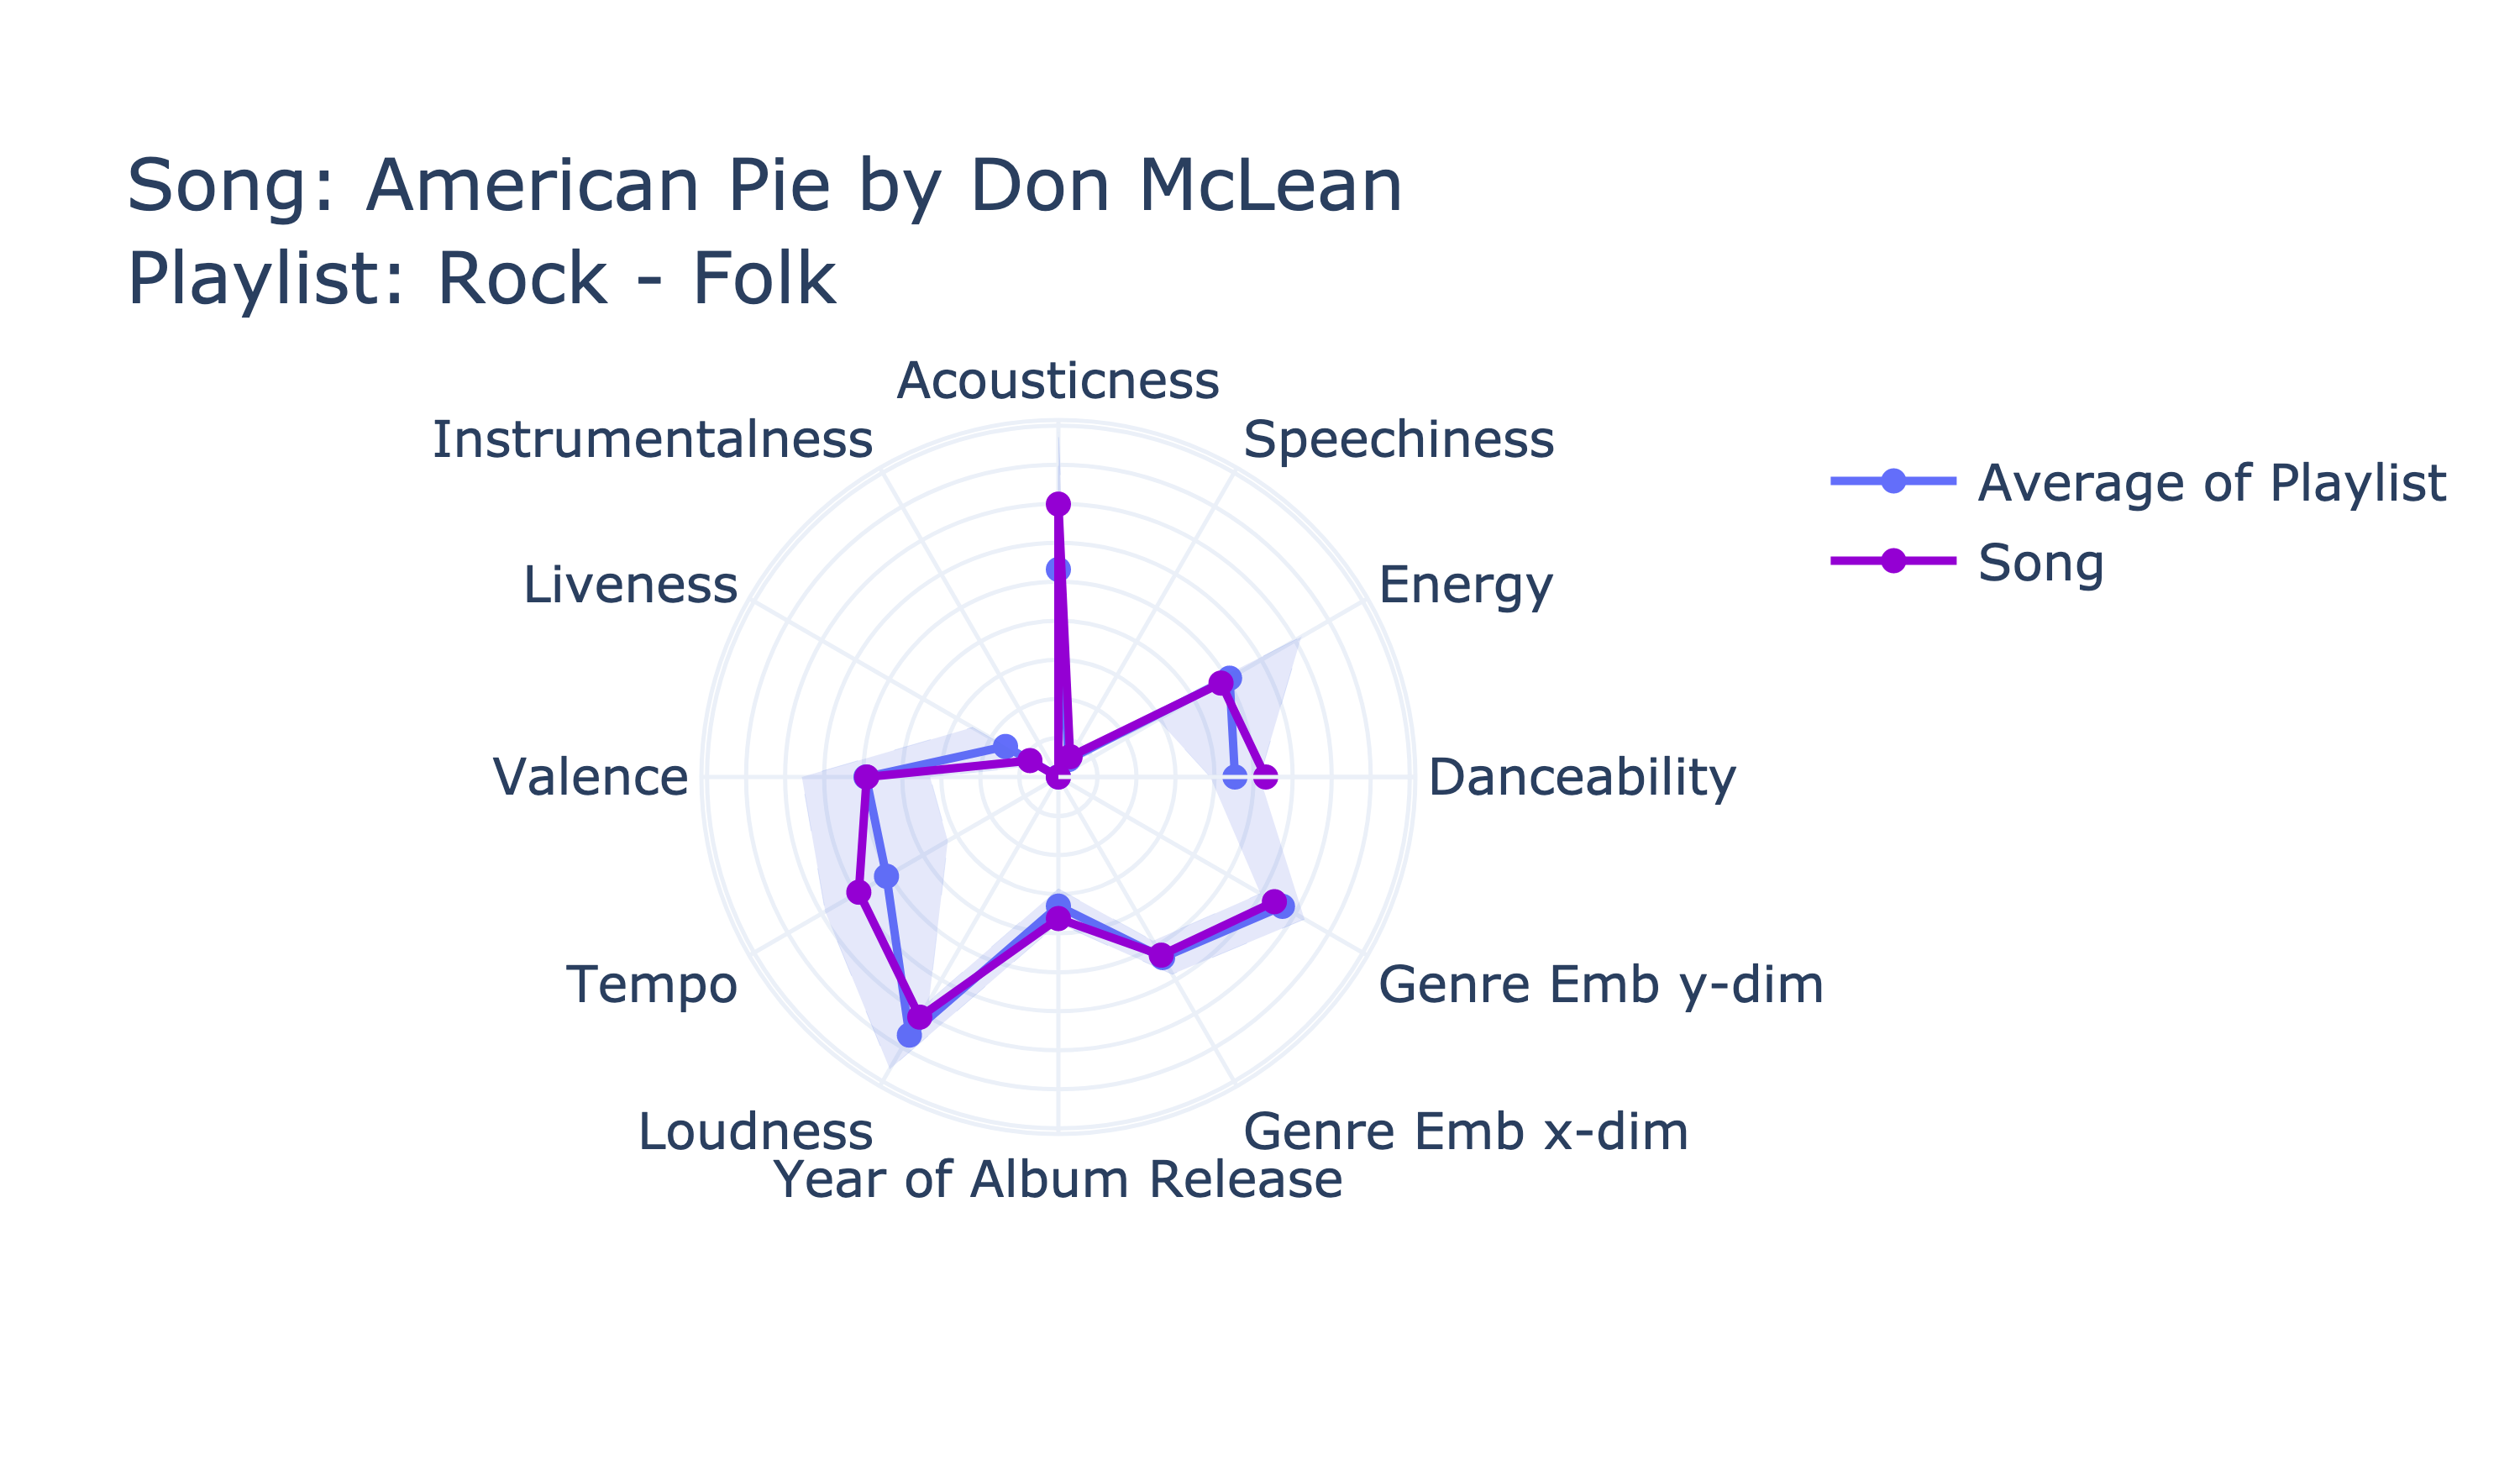

In [23]:
selected_song_id = df_suggested_songs_info.index[-1]
selected_song_name, selected_song_artist = df_features.loc[selected_song_id, ["SongName", "Artist"]]

mood_board = plot_mood_board(
    df_playlist_features[EUCLIDEAN_FEAT_COLS], title="", inline=False, metrics_version=1
)
song_radial_plot_trace = plot_radial_plot(
    df_features.loc[selected_song_id].copy(),
    title=f"{selected_song_name} by {selected_song_artist}",
    only_return_trace=True,
)
mood_board.add_trace(song_radial_plot_trace)
mood_board.update_layout(
    title=f"Song: {selected_song_name} by {selected_song_artist}"
    + "<br>"
    + f"Playlist: {selected_playlist}"
)
# To render correctly when converting notebook to HMTL using quarto
img_bytes = mood_board.to_image(format="png", width=600, height=350, scale=5)
Image(img_bytes)

# Conclusion

So this has been my solution to personalised music recommendation for curating playlists.

I hope this is applicable and useful to how you organise and consume music and please check out the webapp for yourself. It should be fairly easy to get running on your computer. If have any thoughts or trouble with the code, always happy to hear any feedback:)

# References

[1] Lidy, Thomas, and Andreas Rauber. "Evaluation of feature extractors and psycho-acoustic transformations for music genre classification." In ISMIR, pp. 34-41. 2005.

[2] Li, T. L., Antoni B. Chan, and A. H. Chun. "Automatic musical pattern feature extraction using convolutional neural network." Genre 10, no. 2010 (2010): 1x1.